<h1> Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Required imports for neural network
import torch.nn as nn
import torch
from torch.autograd import Variable
import random
import torchvision


<h1> Data Loading and Generation

Omniglot dataset

Note this omniglot dataset has just 1000 images in the paper they report using 1200 for training

In [2]:
# Import omniglot dataset
dataset = torchvision.datasets.Omniglot(
    root="./data", download=True, transform=torchvision.transforms.ToTensor()
)

Files already downloaded and verified


In [3]:
# Create dictionary for all classes there is 50
dataset_classes={}
for i in range(len(dataset)):
  image, label = dataset[i]
  try:
    dataset_classes[f'{label}']= torch.cat((dataset_classes[f'{label}'],image[None,:,:,:]))
  except:
    dataset_classes[f'{label}']=image[None,:,:,:]

  

In [4]:
class Omni:
  x = []
  y = []

In [5]:
# number_of_classes = 964 #Define how money classes to train on, max is 50

# # Create empty lists
# dataset_list_train = []
# dataset_list_train_label = []
# dataset_list_test = []
# dataset_list_test_label = []

# # Extract traning data
# for label in range(number_of_classes):
#   for j in range(len(dataset_classes[f'{label}'])-1):
#     dataset_list_train.append(dataset_classes[f'{label}'][j])
#     dataset_list_train_label.append(label)

# # Shuffle training data and labels
# zip_train_for_shuffling = list(zip(dataset_list_train,dataset_list_train_label))
# random.shuffle(zip_train_for_shuffling)
# dataset_list_train,dataset_list_train_label = zip(*zip_train_for_shuffling)

# # Extr<ct test data
# for label in range(number_of_classes):
#   dataset_list_test.append(dataset_classes[f'{label}'][-1])
#   dataset_list_test_label.append(label)

# # Shuffle test data and labels
# zip_test_for_shuffling = list(zip(dataset_list_test,dataset_list_test_label))
# random.shuffle(zip_test_for_shuffling)
# dataset_list_test,dataset_list_test_label = zip(*zip_test_for_shuffling)

# OMNI_TRAIN=[]
# for _ in range(len(dataset_list_train_label)):
#   OMNI_TRAIN.append(Omni())

# OMNI_TEST=[]
# for _ in range(len(dataset_list_test_label)):
#   OMNI_TEST.append(Omni())

# for i in range(len(dataset_list_train_label)):
#   OMNI_TRAIN[i].x = dataset_list_train[i][None,:,:,:]
#   OMNI_TRAIN[i].y = dataset_list_train_label[i]

# for i in range(len(dataset_list_test_label)):
#   OMNI_TEST[i].x = dataset_list_test[i][None,:,:,:]
#   OMNI_TEST[i].y = dataset_list_test_label[i]



<h1> Neural Network Model

In [6]:
# Define network
class Neural_Network(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=964):
        super(Neural_Network, self).__init__()
        # network layers
        self.hidden1 = nn.Conv2d(input_size,hidden_size,kernel_size=3)
        self.hidden2 = nn.Conv2d(hidden_size,hidden_size,kernel_size=3)
        self.hidden3 = nn.Conv2d(hidden_size,hidden_size,kernel_size=3)
        self.hidden4 = nn.Conv2d(hidden_size,hidden_size,kernel_size=3)
        self.batchnorm = nn.BatchNorm2d(hidden_size)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(1024,output_size)

        #Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)



        
    def forward(self, x):

        # Convolutional part
        x = self.hidden1(x)
        x = self.batchnorm(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.batchnorm(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.hidden3(x)
        x = self.batchnorm(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.hidden4(x)
        x = self.batchnorm(x)
        x = self.maxpool(x)
        x = self.relu(x)

        # Fully-connected part
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)

        return x


<h1> Helper functions

In [7]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.BCELoss()

def transform_label(label,K=5):
    label_tensor=torch.zeros((1,964))
    label_tensor[:,label]=1

    return label_tensor.repeat(K, 1).float()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,omni,lr_inner,k,store_test_loss_meta,K=1):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, omni, lr_inner, k,K)
    # Obtain the loss
    loss = evaluation(new_model, omni,K)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,omni,store_train_loss_meta,K):
    loss = evaluation(new_model, omni,K)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, omni, K, item = True):
    # Get data
    x, label = omni.x,omni.y
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,transform_label(label,K=K)).item()
    else:
      loss = criterion(prediction,transform_label(label,K=K))
    return loss

def training(model, omni, lr_k, k, K):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, omni, K, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

<h1> Reptile

In [8]:
#Define important variables
epochs = int(1e4) # number of epochs 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=100 # how many epochs should we wait to print the loss
lr_k=0.0005 # Internal learning rate
k=5 # Number of internal updates for each task

# Training loop
K = 5 #Max is 20
number_of_tasks = 963 #Max 964

# Initializations
initialization_to_store_meta_losses()
model = Neural_Network()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta,betas=(0, 0.999))

In [9]:

for epoch in range(epochs):
        
    # Sample a sine omni (Task from training data)
    label = random.randint(0,number_of_tasks-1)
    sampling = random.randint(0,15)
    #need a random shuffle function
    data = dataset_classes[f'{label}'][sampling:sampling+5,:,:,:]
    omni = Omni()
    omni.x = data
    omni.y = label

    # Update model predefined number of times based on k
    new_model = training(model, omni, lr_k, k,K=K)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,omni,store_train_loss_meta,K=K)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the omni from the test data
    # Sample a sine omni (Task from training data)
    label = 963
    data = dataset_classes[f'{label}'][sampling:sampling+5,:,:,:]
      
    omni = Omni()
    omni.x = data
    omni.y = label


    test_set_validation(model,new_model,omni,lr_k,k,store_test_loss_meta,K=K)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epochh : 0, Average Train Meta Loss : 0.007717070169746876, Average Test Meta Loss : 0.008455774746835232


KeyboardInterrupt: ignored

In [10]:
torch.save(model, 'reptile_classification')

In [11]:
model = torch.load('reptile_classification')

<h1> Few Shot learning with new meta-model

The model performs good few shot learning

Text(0.5, 0, 'k shots')

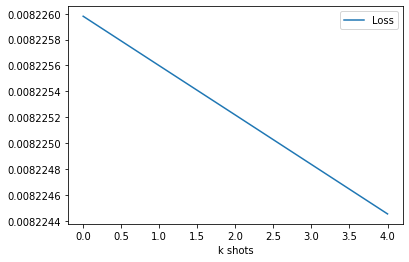

In [12]:
label = 963
data = dataset_classes[f'{label}'][0:K,:,:,:]
      
omni = Omni()
omni.x = data
omni.y = label
k_shot_updates = 5
initialization_to_store_meta_losses()
for shots in range(k_shot_updates):
    new_model = training(model, omni, lr_k, shots,K)
    train_set_evaluation(new_model,omni,store_train_loss_meta,K) 

plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')

In [ ]:
label

2